# Load Dataset

In [1]:
import pandas as pd

df_credit = pd.read_csv("data/default_of_credit_card_clients.csv")
df_credit.drop(columns="ID", axis=1, inplace=True)

In [2]:
df_credit.rename(columns={"default payment next month": "IsDefault"}, inplace=True)
df_credit

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,IsDefault
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3,1,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


# Train Simple Model

In [3]:
# 1. define model pipeline

from src.model_pipeline import ModelPipeline

pipeline = ModelPipeline(
    # choose among ['logistic_regression', 'random_forest', 'gradient_boosting', 'xgboost', 'svm']
    model_type="random_forest",
    random_state=42,
)

/home/gregorius_vidy/anaconda3/envs/bespoke-model/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 2. Prepare dataset

X, y, num_cols, cat_cols = pipeline.prepare_data(
    df=df_credit,
    target_column="IsDefault",
    exclude_columns=None,  # e.g. drop IDs or timestamps if present
    categorical_columns=None,  # auto-detect cats if None
)

In [5]:
# 3. Split data train and test

splits = pipeline.split_data(X, y, test_size=0.3)

In [6]:
# 4. Build preprocessing + model pipeline

pipeline.build_pipeline(numerical_columns=num_cols, categorical_columns=cat_cols)

In [7]:
# 5. Train on the training fold

pipeline.train(splits["X_train"], splits["y_train"])

In [8]:
# 6. Evaluate on the test fold
metrics = pipeline.evaluate(splits["X_test"], splits["y_test"])
print(
    f"Test set metrics -> Accuracy: {metrics['accuracy']:.4f}, "
    f"AUC: {metrics['auc']:.4f}"
)

Accuracy: 0.8134
AUC: 0.7627
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.65      0.34      0.45      1991

    accuracy                           0.81      9000
   macro avg       0.74      0.64      0.67      9000
weighted avg       0.79      0.81      0.79      9000

Test set metrics -> Accuracy: 0.8134, AUC: 0.7627


In [9]:
from sklearn.metrics import roc_auc_score
import numpy as np


def find_best_threshold(y_true, y_probs):
    best_threshold = 0.0
    best_auc = 0.0

    thresholds = np.arange(0.0, 1.0, 0.01)
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        auc = roc_auc_score(y_true, y_pred)
        if auc > best_auc:
            best_auc = auc
            best_threshold = threshold

    return best_threshold, best_auc

In [9]:
# 7. Perform 5-fold stratified cross-validation
cv_scores = pipeline.cross_validate(X, y, cv=5)
print(f"CV ROC AUC scores: {cv_scores}")
print(f"Mean CV AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 8. Inspect the top 10 features driving model predictions
fi = pipeline.get_feature_importance(X, y)
print(fi.head(10))

CV folds:  20%|██        | 1/5 [00:04<00:17,  4.35s/it]

Fold 1/5 AUC: 0.7704


CV folds:  40%|████      | 2/5 [00:08<00:13,  4.37s/it]

Fold 2/5 AUC: 0.7657


CV folds:  60%|██████    | 3/5 [00:13<00:08,  4.38s/it]

Fold 3/5 AUC: 0.7624


CV folds:  80%|████████  | 4/5 [00:17<00:04,  4.37s/it]

Fold 4/5 AUC: 0.7671


CV folds: 100%|██████████| 5/5 [00:21<00:00,  4.38s/it]

Fold 5/5 AUC: 0.7600
CV ROC AUC scores: [0.77035244 0.76571313 0.76241822 0.76707757 0.7600146 ]
Mean CV AUC: 0.7651 ± 0.0036
          feature  importance
0  num__LIMIT_BAL    0.060318
1        num__AGE    0.060191
2      num__PAY_0    0.097917
3      num__PAY_2    0.041790
4      num__PAY_3    0.027960
5      num__PAY_4    0.024551
6      num__PAY_5    0.016400
7      num__PAY_6    0.020588
8  num__BILL_AMT1    0.059909
9  num__BILL_AMT2    0.053070


In [10]:
# 9. Get the trained model and pipeline

clf = pipeline.get_model()
full_pp = pipeline.get_pipeline()
preprocessor = pipeline.get_preprocessor()

In [35]:
import uuid
import numpy as np

bins = np.arange(0, 1.025, 0.025)
pred_df = {
    "id": [uuid.uuid4() for _ in range(len(X))],
    "pbad": clf.predict_proba(preprocessor.transform(X))[:, 1],
    # 'pbad_bin': pd.qcut(clf.predict_proba(preprocessor.transform(X))[:, 1], q=7),
    "pbad_bin": pd.cut(
        clf.predict_proba(preprocessor.transform(X))[:, 1],
        bins=bins,
        include_lowest=True,
        right=False,
    ),
    "pgood": clf.predict_proba(preprocessor.transform(X))[:, 0],
    # 'pgood_bin': pd.qcut(clf.predict_proba(preprocessor.transform(X))[:, 0], q=7),
    "pgood_bin": pd.cut(
        clf.predict_proba(preprocessor.transform(X))[:, 0],
        bins=bins,
        include_lowest=True,
        right=False,
    ),
    "is_bad": y,
    "is_good": 1 - y,
    "total_limit_amt": X.LIMIT_BAL,
    "total_bad_limit_amt": X.apply(
        lambda row: row.LIMIT_BAL if y[row.name] == 1 else 0, axis=1
    ),
    "total_good_limit_amt": X.apply(
        lambda row: row.LIMIT_BAL if y[row.name] == 0 else 0, axis=1
    ),
}
pred_df = pd.DataFrame(pred_df)

In [16]:
best_threshold, best_auc = find_best_threshold(pred_df["is_good"], pred_df["pgood"])
print(f"Best Threshold: {best_threshold}, Best AUC: {best_auc}")

Best Threshold: 0.81, Best AUC: 0.897661639535701


In [53]:
import numpy as np

aggregated_df = pred_df.groupby("pgood_bin").agg(
    {
        "id": "count",
        "is_bad": "sum",
        "is_good": "sum",
        "total_limit_amt": "sum",
        "total_bad_limit_amt": "sum",
        "total_good_limit_amt": "sum",
    }
)

/tmp/ipykernel_57984/2788757332.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = pred_df.groupby('pgood_bin').agg(


In [54]:
aggregated_df["bad_rate"] = np.divide(aggregated_df["is_bad"], aggregated_df["id"])
aggregated_df["good_rate"] = np.divide(aggregated_df["is_good"], aggregated_df["id"])
aggregated_df["cum_records_passed"] = aggregated_df["id"][::-1].cumsum()[::-1]
aggregated_df["cum_records_rejected"] = aggregated_df["id"].cumsum()
aggregated_df["cum_good"] = aggregated_df["is_good"][::-1].cumsum()[::-1]
aggregated_df["cum_bad"] = aggregated_df["is_bad"][::-1].cumsum()[::-1]
aggregated_df["pass_through_rate"] = np.divide(
    aggregated_df["cum_records_passed"], aggregated_df["id"].sum()
)
aggregated_df["rejection_rate"] = np.divide(
    aggregated_df["cum_records_rejected"], aggregated_df["id"].sum()
)
aggregated_df["cum_good_rate"] = np.divide(
    aggregated_df["cum_good"], aggregated_df["cum_records_passed"]
)
aggregated_df["cum_bad_rate"] = np.divide(
    aggregated_df["cum_bad"], aggregated_df["cum_records_passed"]
)
aggregated_df["cum_limit_amt"] = aggregated_df["total_limit_amt"][::-1].cumsum()[::-1]
aggregated_df["cum_bad_limit_amt"] = aggregated_df["total_bad_limit_amt"][
    ::-1
].cumsum()[::-1]
aggregated_df["cum_good_limit_amt"] = aggregated_df["total_good_limit_amt"][
    ::-1
].cumsum()[::-1]

In [55]:
aggregated_df.to_clipboard()

In [34]:
pred_df[pred_df["pgood"] >= 0.025].is_bad.value_counts(normalize=False)

is_bad
0    23363
1     6575
Name: count, dtype: int64

In [24]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

print(
    f"AUC: {roc_auc_score(y, clf.predict_proba(preprocessor.transform(X))[:, 1]):.4f}"
)

AUC: 0.9335


# Model Diagnostic

In [11]:
from src.model_diagnostic import TestSuite

ts = TestSuite()

In [12]:
ts.set_data(data=splits, pipeline=full_pp, target_col="IsDefault")

/Users/gregvidy/Personal Project/gbg-bespoke-model/src/model_diagnostic.py:232: UserWarning: Target column not identified. Using last column 'IsDefault' as target.
  warnings.warn(


In [13]:
ts.set_model(model=clf)

/opt/anaconda3/envs/gbg-bespoke-model/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/gbg-bespoke-model/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


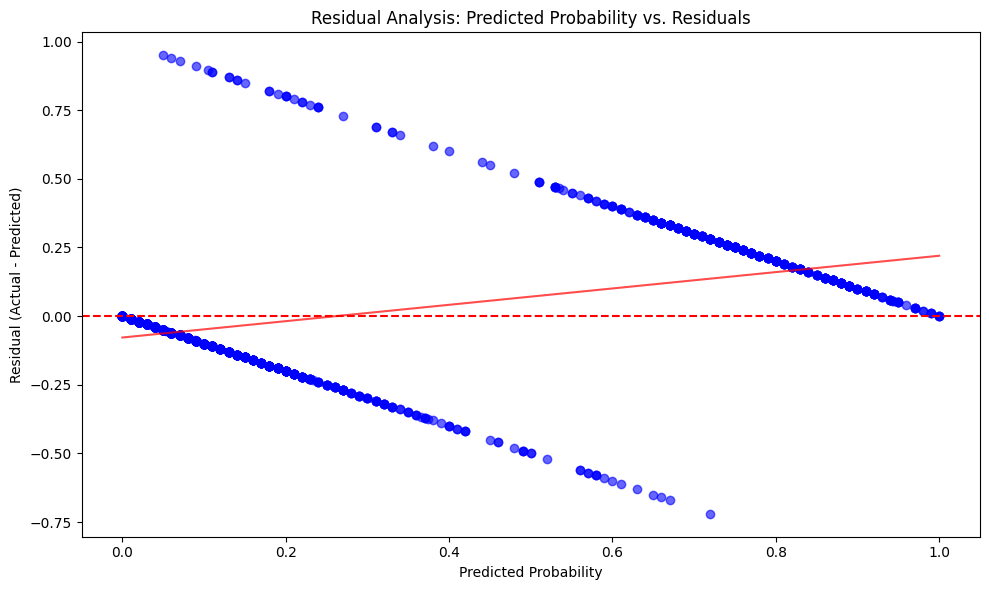

In [15]:
result = ts.diagnose_residual_analysis(
    features="num__PAY_0", use_prediction=True, dataset="test", random_state=123
)